
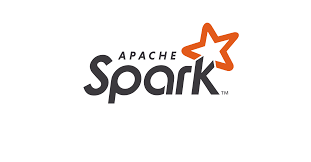

# Problem to solve:  Perform customer segmentation on the e-commerce using Machine Learning

By the end of this lab, you will be familiar with the following concepts:

1. Reading csv files with PySpark
1. Exploratory Data Analysis with PySpark
1. Grouping and sorting data
1. Performing arithmetic operations
1. Aggregating datasets
1. Data Pre-Processing with PySpark
1. Working with datetime values
1. Type conversion
1. Joining two dataframes
1. The rank() function
1. PySpark Machine Learning
1. Creating a feature vector
1. Standardizing data
1. Building a K-Means clustering model
1. Interpreting the model


# Install pyspark

In [1]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 199 kB 53.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=83d75d918c80f8774e3bf109795c19601e21b5bbc5ce1105e238c671112e9954
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Creating a SparkSession

A SparkSession is an entry point into all functionality in Spark, and is required if you want to build a dataframe in PySpark. Run the following lines of code to initialize a SparkSession.

Using the codes bellow, we built a spark session and set a name for the application. Then, the data was cached in off-heap memory to avoid storing it directly on disk, and the amount of memory was manually specified.

In [3]:
from pyspark.sql import SparkSession
import findspark

findspark.init()

spark = SparkSession.builder.appName("Pyspark Tutorial")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()


# check spark configuration

spark

# Creating the DataFrame from a csv

In [5]:
# Download the data first into a local `OnlineRetail.csv` file

!curl https://raw.githubusercontent.com/antonioGoncalves64/pyspark/main/OnlineRetail.csv >> OnlineRetail.csv



df = spark.read.csv('OnlineRetail.csv',header=True,sep=";")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.4M  100 43.4M    0     0  25.2M      0  0:00:01  0:00:01 --:--:-- 25.2M


# Look at the head of the dataframe

In [6]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |01/12/2010 08:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |01/12/2010 08:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |01/12/2010 08:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |01/12/2010 08:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |01/12/2010 08:26|3.39     |17850     |United Kingdom|
+---------+---------+-------------------

The dataframe consists of 8 variables:

* **InvoiceNo:** The unique identifier of each customer invoice.
* **StockCode:** The unique identifier of each item in stock.
* **Description:** The item purchased by the customer.
* **Quantity:** The number of each item purchased by a customer in a single invoice.
* **InvoiceDate:** The purchase date.
* **UnitPrice:** Price of one unit of each item.
* **CustomerID:** Unique identifier assigned to each user.
* **Country:** The country from where the purchase was made

# Exploratory Data Analysis

Perform some exploratory data analysis to further understand these data points:

* Number of rows in the dataframe: **541909**
* How many unique customers are present in the dataframe: **4373**
* What country do most purchases come from: **United Kingdom 3950**
* When was the most recent purchase made by a customer on the e-commerce platform: **2011-06-13 15:30:00**
* When was the earliest purchase made by a customer on the e-commerce platform: **2010-12-01 08:26:00**

## Count the number of rows in the dataframe

In [7]:
df.count()

541909

## Count how many unique customers are present in the dataframe

```
# This is formatted as code
```



In [8]:
df.select('CustomerID').distinct().count()

4373

## What country do most purchases come from

In [9]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|        Denmark|            9|
|         Cyprus|            8|
|          Japan|            8|
|         Sweden|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



## When was the most recent purchase made by a customer on the e-commerce platform?

In [12]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'dd/MM/yy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



## When was the earliest purchase made by a customer on the e-commerce platform?

In [13]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



# Data Pre-processing

Now that we have analyzed the dataset and have a better understanding of each data point, we need to prepare the data to feed into the machine learning algorithm.

we need to create multiple customer segments based on each user’s purchase behavior. 

The variables in this dataset are in a format that cannot be easily ingested into the customer segmentation model. These features individually do not tell us much about customer purchase behavior.

Due to this, we will use the existing variables to derive three new informative features - **Recency**, **Frequency**, and **Monetary value** (_RFM_). 

_RFM_ is commonly used in marketing to evaluate a client’s value based on their:

* **Recency:** How recently has each customer made a purchase?

* **Frequency:** How often have they bought something?

* **Monetary Value:** How much money do they spend on average when making purchases?

We will now preprocess the dataframe to create the above variables.

## Recency

First, let’s calculate the value of recency - the latest date and time a purchase was made on the platform. This can be achieved in two steps:

### Assign a recency score to each customer

We will subtract every date in the dataframe from the earliest date. This will tell us how recently a customer was seen in the dataframe. A value of 0 indicates the lowest recency, as it will be assigned to the person who was seen making a purchase on the earliest date.

In [14]:
df = df.withColumn("from_date", lit("01/12/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'dd/MM/yy HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [15]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [24]:
df2.show(5,0)

+-------+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |from_date          |date               |
+-------+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+-------------------+
|5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |01/12/2010 09:53|6.45     |18074     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|
|5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |01/12/2010 09:53|0.65     |18074     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09:53:00|
|5220   |536384   |22464    |HANGING METAL HEART LANTERN        |12      |01/12/2010 09:53|1.65     |18074     |United Kingdom|2010-12-01 08:26:00|2010-12-01 09

An easier way to view all the variables present in a PySpark dataframe is to use its printSchema() function

In [26]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- date: timestamp (nullable = true)



## Frequency

Let’s now calculate the value of frequency - how often a customer bought something on the platform. To do this, we just need to group by each customer ID and count the number of items they purchased.

In [25]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|17714     |10       |
|16250     |10       |
|15574     |9        |
|16320     |9        |
|17551     |43       |
+----------+---------+
only showing top 5 rows



There is a frequency value appended to each customer in the dataframe. This new dataframe only has two columns, and we need to join it with the previous one

In [27]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



### Monetary Value

Finally, let’s calculate monetary value - the total amount spent by each customer in the dataframe. There are two steps to achieving this:

* Find the total amount spent in each purchase
* Find the total amount spent by each customer

### Find the total amount spent in each purchase
Each customerID comes with variables called “Quantity” and “UnitPrice” for a single purchase. To get the total amount spent by each customer in one purchase, we need to multiply “Quantity” with “UnitPrice”

In [28]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))



###Find the total amount spent by each customer. o find the total amount spent by each customer overall, we just need to group by the CustomerID column and sum the total amount spent

In [29]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

Merge this dataframe with the all the other variables

In [30]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')



Now that we have created all the necessary variables to build the model, run the following lines of code to select only the required columns and drop duplicate rows from the dataframe and look at the head of the final dataframe to ensure that the pre-processing has been done accurately.

In [31]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

finaldf.show(5,0)

+--------+---------+------------------+----------+
|recency |frequency|monetary_value    |CustomerID|
+--------+---------+------------------+----------+
|4586760 |10       |153.0             |17714     |
|9700860 |10       |163.3             |16250     |
|16947300|9        |112.10000000000001|15574     |
|17391540|9        |185.78000000000003|16320     |
|1230360 |43       |306.84            |17551     |
+--------+---------+------------------+----------+
only showing top 5 rows



# Standardization

Before building the customer segmentation model, let’s standardize the dataframe to ensure that all the variables are around the same scale. 

These are the scaled features that will be fed into the clustering algorithm

In [32]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

data_scale_output.select('standardized').show(2,truncate=False)

+-------------------------------------------------------------+
|standardized                                                 |
+-------------------------------------------------------------+
|[0.5258889381294389,0.25819728443703077,0.054732953197302925]|
|[1.1122393507273869,0.25819728443703077,0.05841758991581417] |
+-------------------------------------------------------------+
only showing top 2 rows



# Building the Machine Learning Model

Now that we have completed all the data analysis and preparation, let’s build the K-Means clustering model. 



## Finding the number of clusters to use

When building a K-Means clustering model, we first need to determine the number of clusters or groups we want the algorithm to return. If we decide on three clusters, for instance, then we will have three customer segments.

The most popular technique used to decide on how many clusters to use in K-Means is called the “elbow-method.”

This is done simply running the K-Means algorithm for a wide range of clusters and visualizing the model results for each cluster. The plot will have an inflection point that looks like an elbow, and we just pick the number of clusters at this point.

Let’s run the following lines of code to build a K-Means clustering algorithm from 2 to 10 clusters.

In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

With the codes above, we have successfully built and evaluated a K-Means clustering model with 2 to 10 clusters. The results have been placed in an array, and can now be visualized in a line chart.

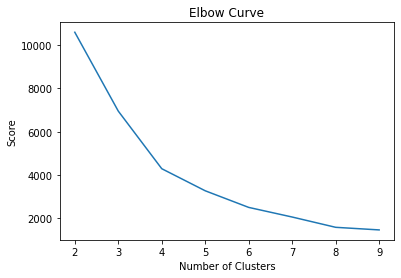

In [34]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

## Building the K-Means Clustering Model

From the plot above, we can see that there is an inflection point that looks like an elbow at four. Due to this, we will proceed to build the K-Means algorithm with four clusters

In [35]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

## Making Predictions

Let’s use the model we created to assign clusters to each customer in the dataset:

In [36]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+--------+---------+------------------+----------+-----------------------------------+-------------------------------------------------------------+----------+
|recency |frequency|monetary_value    |CustomerID|features                           |standardized                                                 |prediction|
+--------+---------+------------------+----------+-----------------------------------+-------------------------------------------------------------+----------+
|4586760 |10       |153.0             |17714     |[4586760.0,10.0,153.0]             |[0.5258889381294389,0.25819728443703077,0.054732953197302925]|0         |
|9700860 |10       |163.3             |16250     |[9700860.0,10.0,163.3]             |[1.1122393507273869,0.25819728443703077,0.05841758991581417] |0         |
|16947300|9        |112.10000000000001|15574     |[1.69473E7,9.0,112.10000000000001] |[1.943070402890284,0.2323775559933277,0.0401017258393311]    |0         |
|17391540|9        |185.78000000000003|1

Notice that there is a “prediction” column in this dataframe that tells us which cluster each CustomerID belongs to:

## Cluster Analysis

The final step in this entire tutorial is to analyze the customer segments we just built.

Run the following lines of code to visualize the recency, frequency, and monetary value of each customerID in the dataframe:

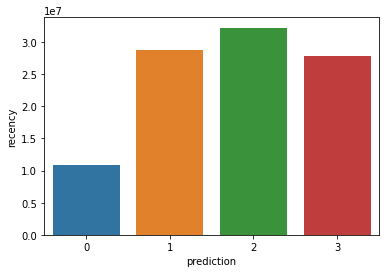

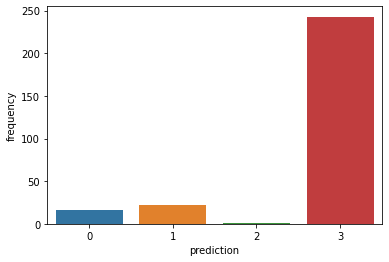

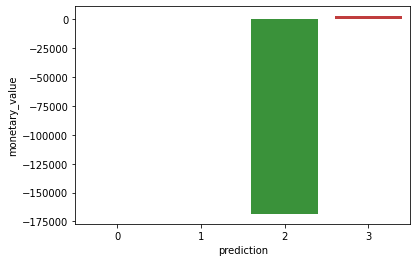

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

Here is an overview of characteristics displayed by customers in each cluster:

* Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.


* Cluster 1: Users in this cluster display medium high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.

* Cluster 2: Customers in this segment display high recency and low frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.

* Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.
